# This is the CellPose Demo Notebook
## For the Crick 3D Segmenation Course, September 2024
### Todd Fallesen CALM

# Do the imports of packages

In [44]:
from cellpose import models, io
from cellpose.io import imread

import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io
from tifffile import imread, imwrite
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible
from glob import glob

from stardist import fill_label_holes, random_label_cmap

from skimage import filters
from skimage.segmentation import clear_border
from skimage.transform import rescale, resize, downscale_local_mean

import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)
lbl_cmap = random_label_cmap()


import os
#https://cellpose.readthedocs.io/en/latest/faq.html

# Import files

In [29]:
image_path = "C:\\3D_Segmentation\\3d_monolayer_xy1_ch2.tif"
#image_path = "C:\\3D_Segmentation\\*.tif" #path where images are
save_path = "C:\\3D_Segmentation\\output\\Cellpose\\"

In [30]:
X = sorted(glob(image_path))
X = X
file_list = []
for name in X:
    file_list.append(os.path.basename(name))
    
X = [image_path] # put this in a list, so if we want to change this to iterate through multiple images later, it's easier
X = list(map(imread,X))

In [31]:
#Check the files were listed correctly
file_list

['3d_monolayer_xy1_ch2.tif']

## Show a demo image

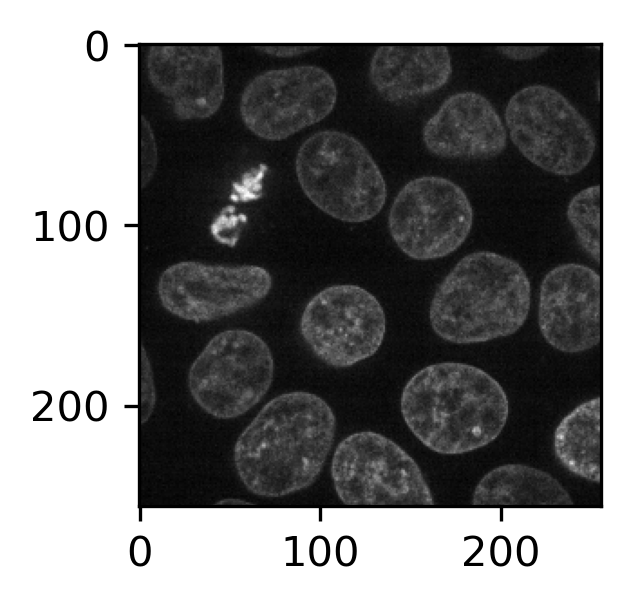

In [32]:

plt.figure(figsize=(4,2))
plt.imshow(X[0][X[0].shape[0]//2],cmap='gray')

# Any image pre-processing

(60, 256, 256)

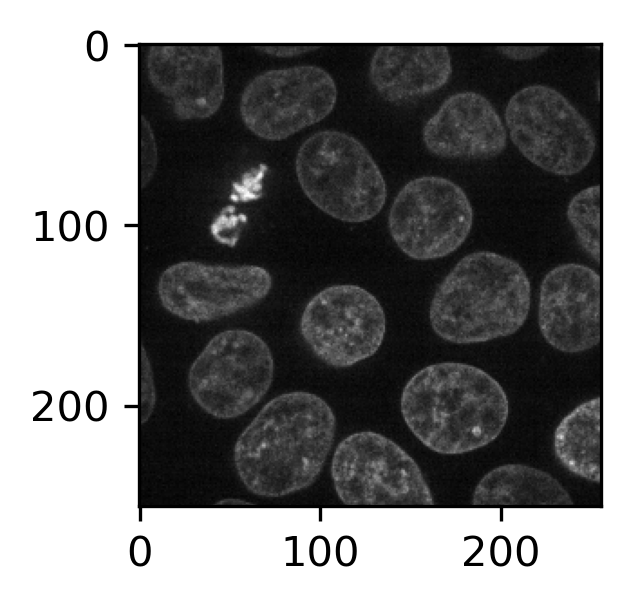

In [33]:
Do_Rescale = False
Do_Gauss = False
Do_Median = False

sigma = 1
rescale_factor = 0.5

if Do_Rescale:
    for i in range(0,len(files)):
        X[i] = rescale(X[i], (1,rescale_factor, rescale_factor), anti_aliasing=False)

if Do_Gauss:
    for i in range(0,len(X)):
        X[i] = filters.gaussian(X[i], sigma=sigma)
        
if Do_Median:
    for i in range(0,len(X)):
        files[i] = filters.median(X[i], sigma=sigma)
        

# show all test images

plt.figure(figsize=(4,2))
plt.imshow(X[0][X[0].shape[0]//2],cmap='gray')

X[0].shape

# Set up Cellpose model

## There are four different model types in CellPose
* cyto
* nuclei
* cyto2
* cyto3

You need to choose one to be your model.

You also have to specify your diameter

In [34]:
#model_type='cyto' or 'nuclei' or 'cyto2' or 'cyto3'
model_type = 'nuclei'   # choose your model
diameter = 60           # estimate the diameter of your objects. You can set to 'None' to auto find the diameters, but it's slow
gpu_on = False          #set to true if you have a GPU. Most laptops don't. 
anisotropy = 1          # aniostropy of your sample, or how much X and Y scale differently from Z
stitch_threshold = 0.4  # amount of overlap needed in second method to combine segmentations into 3D

In [35]:
Run_Demo = True


# Run CellPose

## There are two methods to run
    Cellpose will run in it's own 3D format, where it will need to use the anisotropy of the sample, and try to do the 3D segmentation all at once. Calculating over X-Y, Y-Z and X-Z as orthogonal images
    
    Cellpose can also do something similar to what we did in Trackmate, where it just segments X-Y slices and stitches them together by overlap
    
    

### 3D Cellpose

In [36]:
## These blocks show the 3D method, using 3D space, using CellPose in X-Y, Y-Z, X-Z

if Run_Demo:
    model = models.Cellpose(gpu=gpu_on,model_type=model_type)
    img = X[0]
    masks, flows, styles, diams = model.eval(img, diameter=diameter, channels=[0,0],
                                                     flow_threshold=0.4, anisotropy=anisotropy, do_3D=True)
    if len(np.shape(masks))==4:
        masks = masks[0] #trim off the 1st dimension which doesn't matter
    else:
        masks = masks
else:
    print("Run Demo wasn't set to true. Run demo didn't run")

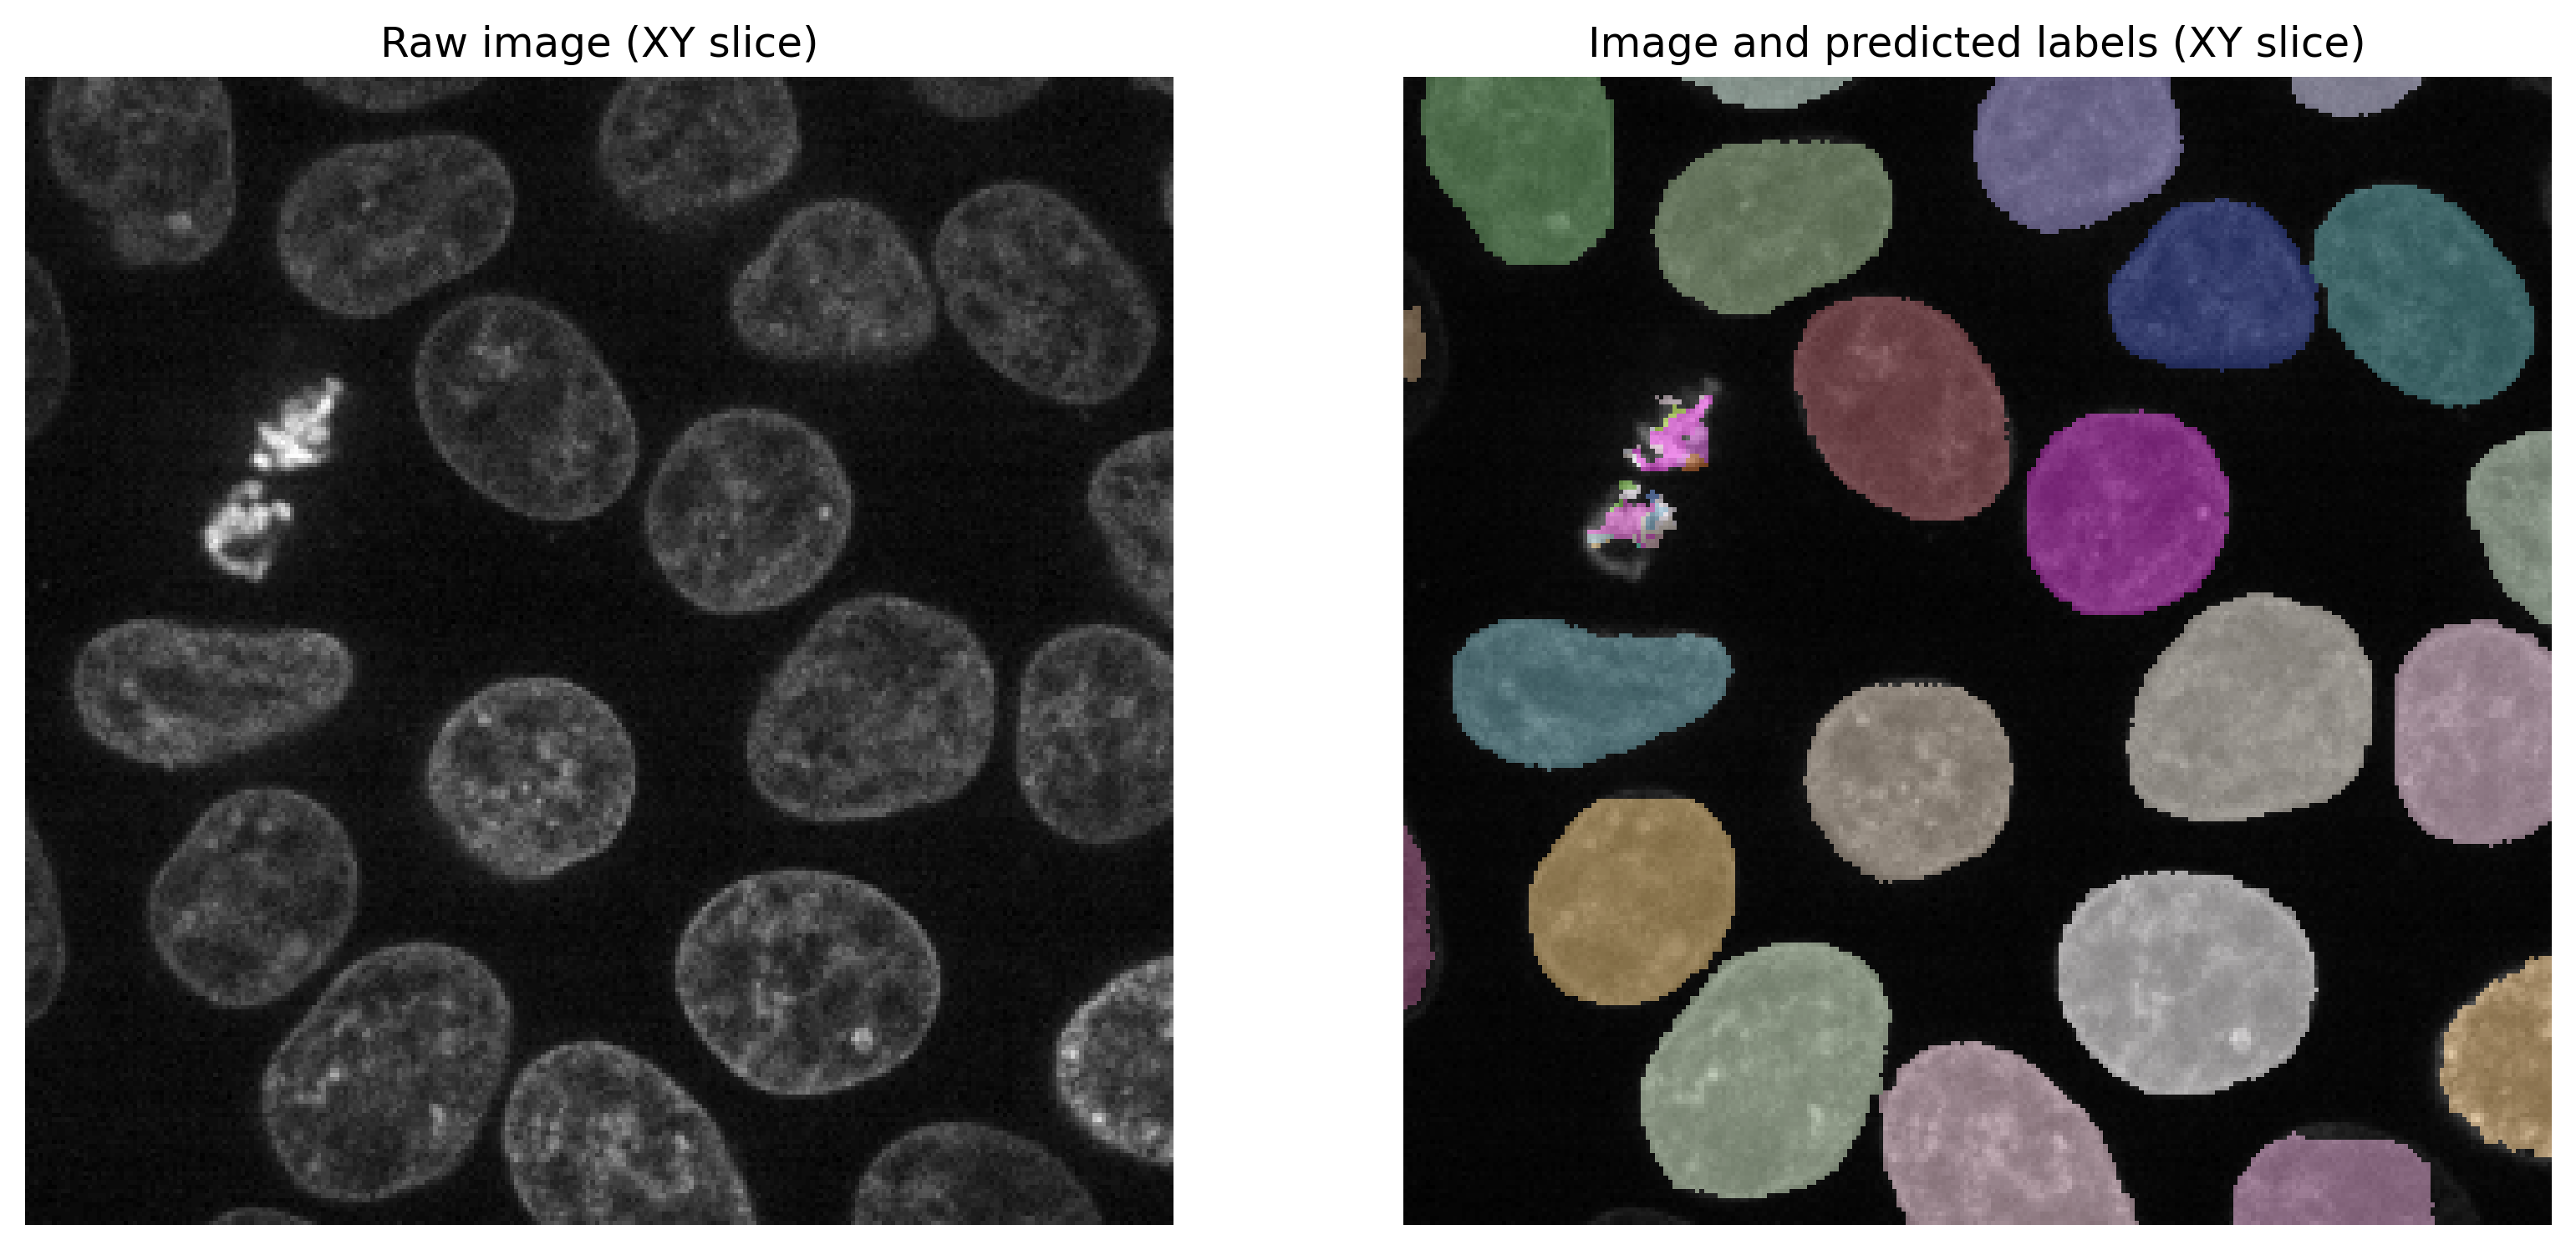

In [38]:
if Run_Demo:
    plt.figure(figsize=(13,10))
    z = max(0, X[0].shape[0] // 2 )
    plt.subplot(121)
    #plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
    plt.imshow(X[0][X[0].shape[0]//2],cmap='gray')
    plt.title('Raw image (XY slice)')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(X[0][X[0].shape[0]//2],cmap='gray')
    plt.imshow(masks[z], cmap=lbl_cmap, alpha=0.5)
    plt.title('Image and predicted labels (XY slice)')
    plt.axis('off');

else:
    print("Run Demo wasn't set to true. Run demo didn't run")

### Stitching Cellpose

In [39]:
## These blocks show the Stitching method, like Trackmate

if Run_Demo:
    model = models.Cellpose(gpu=gpu_on,model_type=model_type)
    img = X[0]
    masks, flows, styles, diams = model.eval(img, diameter=diameter, channels=[0,0],
                                                 flow_threshold=0.4, stitch_threshold=stitch_threshold, do_3D=False)
    if len(np.shape(masks))==4:
        masks = masks[0] #trim off the 1st dimension which doesn't matter
    else:
        masks = masks
else:
    print("Run Demo wasn't set to true. Run demo didn't run")

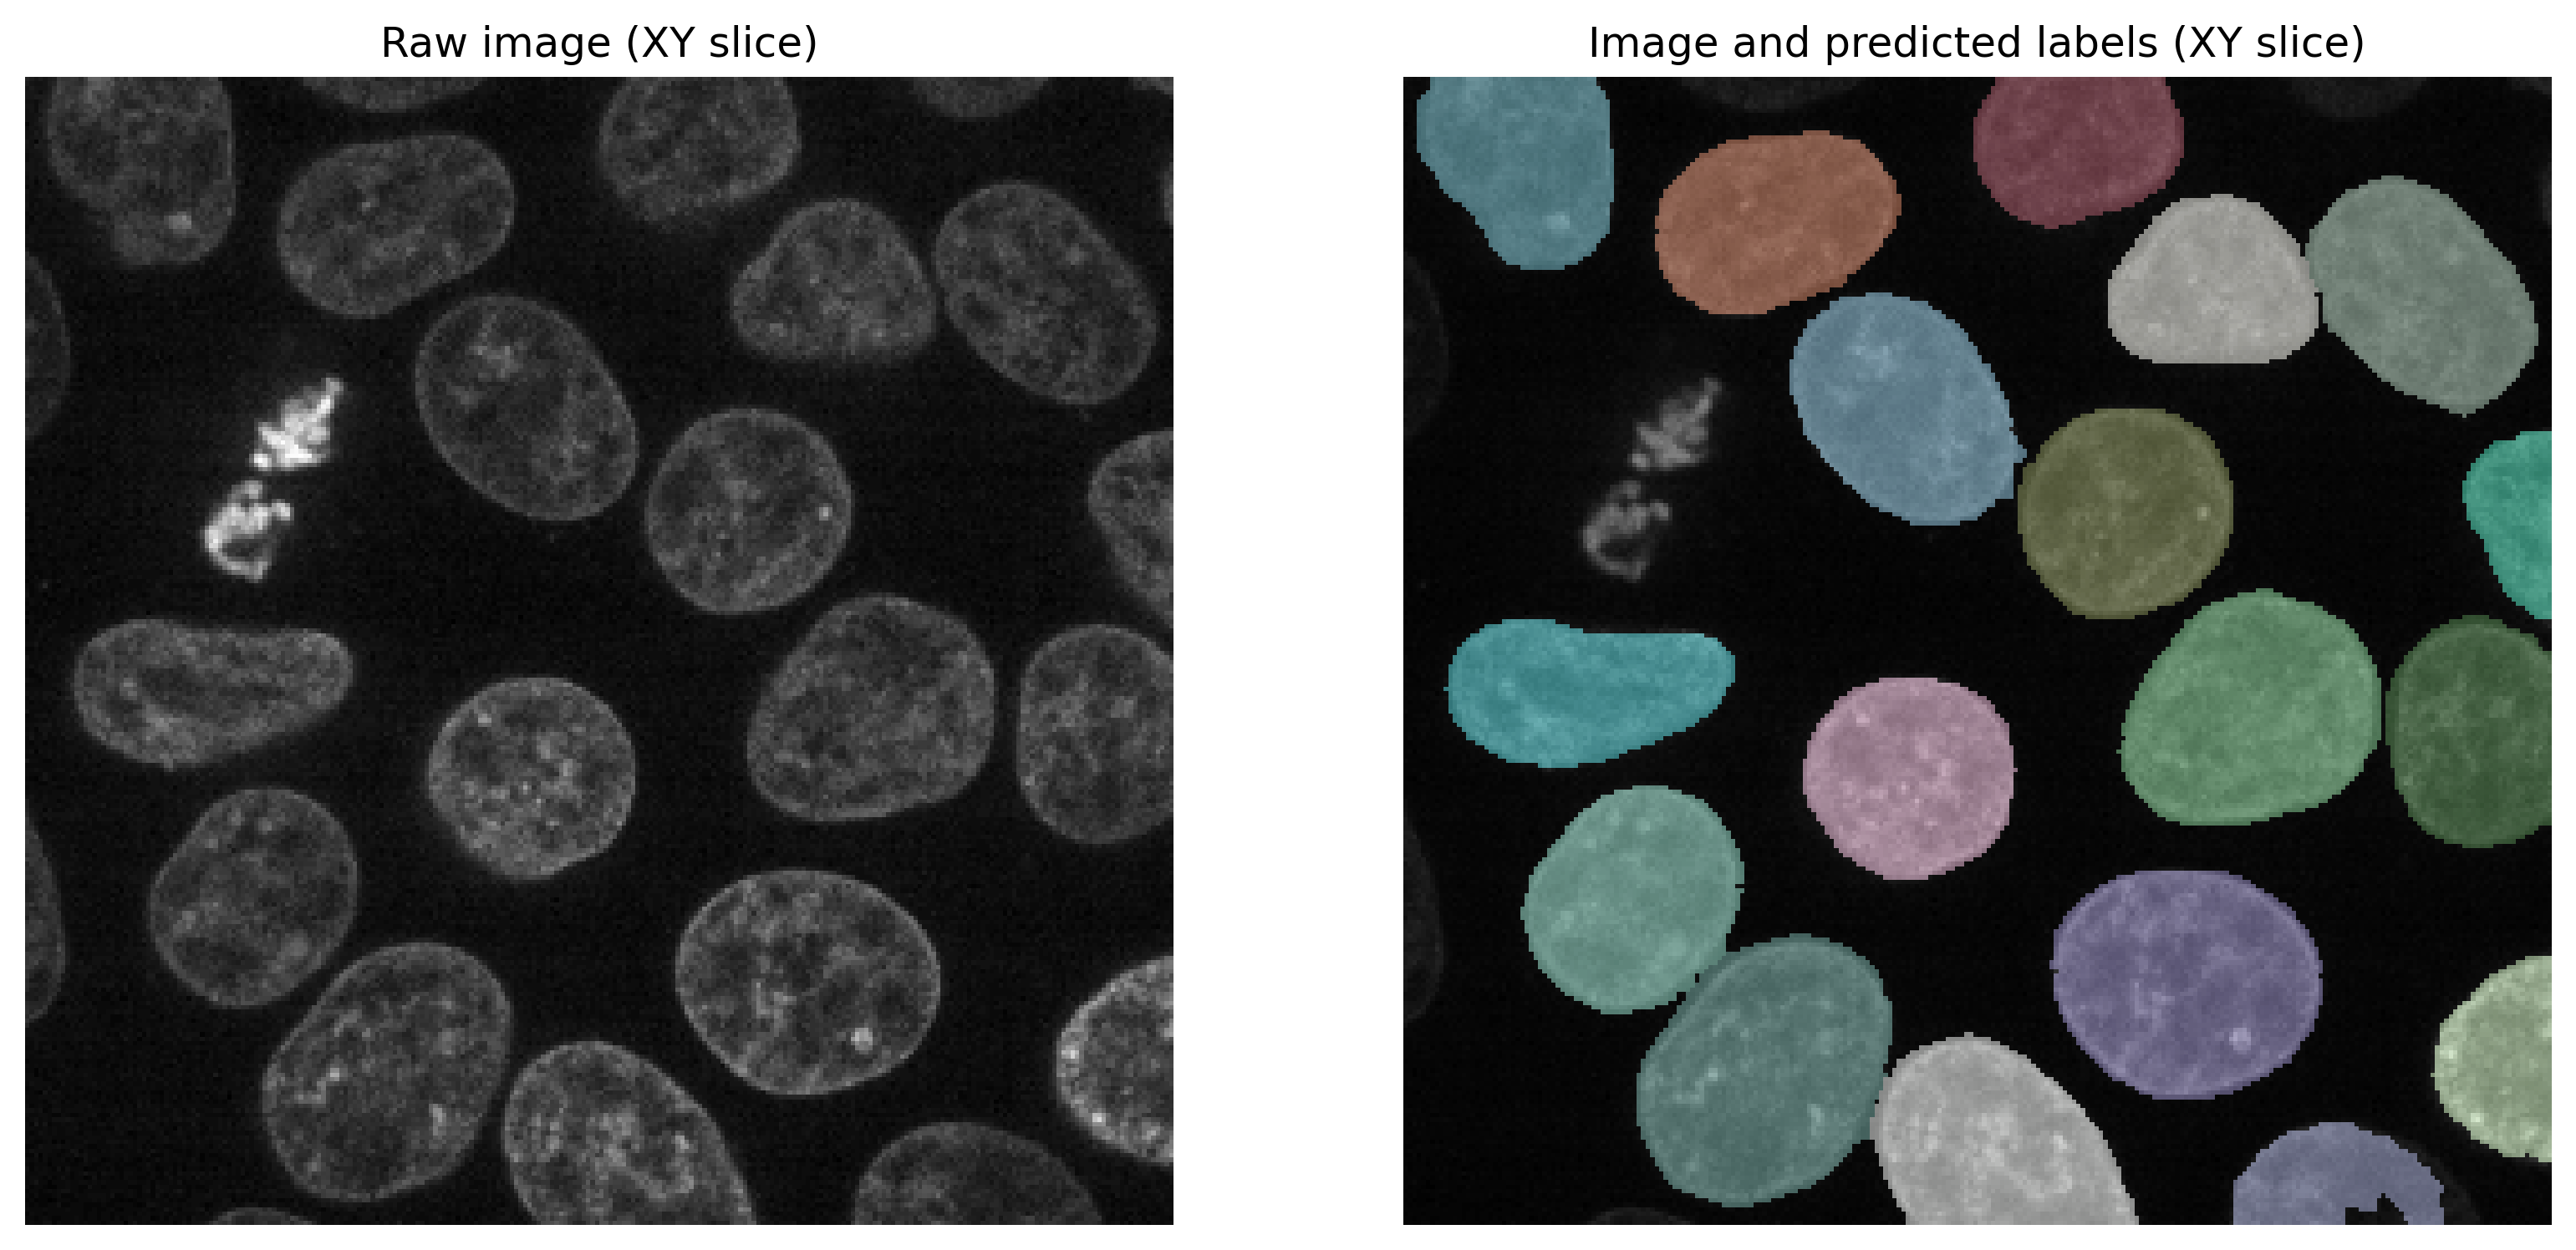

In [40]:
if Run_Demo:
    plt.figure(figsize=(13,10))
    z = max(0, X[0].shape[0] // 2 )
    plt.subplot(121)
    #plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
    plt.imshow(X[0][X[0].shape[0]//2],cmap='gray')
    plt.title('Raw image (XY slice)')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(X[0][X[0].shape[0]//2],cmap='gray')
    plt.imshow(masks[z], cmap=lbl_cmap, alpha=0.5)
    plt.title('Image and predicted labels (XY slice)')
    plt.axis('off');

else:
    print("Run Demo wasn't set to true. Run demo didn't run")

## Run the series and save

In [48]:
#Pick a Segmentation_Type (3D or Stitching)
Segmentation_Type = 'Stitching'

for i in range(0,len(X)):
    if Segmentation_Type=='3D':
        model = models.Cellpose(gpu=gpu_on,model_type=model_type)
        img = X[i]
        masks, flows, styles, diams = model.eval(img, diameter=diameter, channels=[0,0],
                                                     flow_threshold=0.4, anisotropy=anisotropy, do_3D=True)
        if len(np.shape(masks))==4:
            masks = masks[0] #trim off the 1st dimension which doesn't matter
        else:
            masks = masks
    
    if Segmentation_Type == 'Stitching':
        model = models.Cellpose(gpu=gpu_on,model_type=model_type)
        img = X[i]
        masks, flows, styles, diams = model.eval(img, diameter=diameter, channels=[0,0],
                                                     flow_threshold=0.4, stitch_threshold=stitch_threshold, do_3D=False)
        if len(np.shape(masks))==4:
            masks = masks[0] #trim off the 1st dimension which doesn't matter
        else:
            masks = masks
    os.makedirs(save_path, exist_ok=True) if not os.path.exists(save_path) else None      
    #save_file = save_path+os.path.basename(file_list[i])[:-4]+'_3D_Processed_Masks_diameter_'+str(diameter)+'_model_type_'+model_type+"Seg_Type_"+Segmentation_Type+'.tif'
    save_file = save_path+os.path.basename(file_list[i])[:-4]+'_Seg_Type_'+Segmentation_Type+'.tif'
    imwrite(save_file, masks)
    print('Saved the masks to: ', save_file)

Saved the masks to:  C:\3D_Segmentation\output\Cellpose\3d_monolayer_xy1_ch2_Seg_Type_Stitching.tif
